# Contrôle du fichier d'annotations COCO

In [21]:
#import des librairies
import os
import sys
import time
import numpy as np
import random
import colorsys
from pathlib import Path

from pycocotools.coco import COCO
from pycocotools import mask as maskUtils

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib
import skimage.io
from skimage.measure import find_contours

# Création d'une classe dédiée 
Elle hérite de la classe COCO de pycocotools.coco.
Elle permet de de lire le fichier annotations au format COCO et d'en extraire les informations sur le jeu de vérité terrain et de le visualiser.

In [48]:
# Class Dataset pour visualisation
class DataViewer(COCO) :
    def __init__(self, annotation_file, dir_images, dir_labels) :
        '''
        annotion_file for specified zoom (str)
        dir_tiles directory where Images/labels folders are (str)
        zoom (str)
        '''
        COCO.__init__(self, annotation_file)
        self.annotation_file = annotation_file
        self.dir_images = Path(dir_images)
        self.dir_labels = Path(dir_labels)


    '''
    Part 1 : Information from annotations file

    '''      
    def infos(self) :
        '''
        return informations in "infos" section of annotations file
        '''   
        print("Informations")
        print("============")
        self.info()
        print("____________")
        print()

    def categories(self):
        '''
        return informations in  "categories" of annotations file
        '''  
        print("Categories")
        print("============")
        print("Numbers of categegory in this dataset",len(self.dataset['categories']))
        for cat in self.dataset['categories'] :
            print( "Supercategory ", cat['supercategory'])
            print( "Category ", cat['name'])
            print( "Class ID ", cat['id'])
        print("____________")    
        print()

    def images(self,limit=10) :
        ''' 
        limit : (int) number of images informations to show. Default is 10.
        return number of images
        and the list of images
        '''
        print("Images")
        print("============")
        print("Number of images in the Dataset : ", len(self.dataset['images']))
        print("____________")
        if limit>0 :
            print(f'{limit} first images of the dataset')
            for im in self.dataset['images'][:limit] :
                print(im)
        print("____________")
        print()


    def image_with_class (self,cat_id) :  
        '''
        cat_id : (int) id of the class id of interest
        return a list of image_id that contains object of catID
        '''                
        for i in range (len (self.dataset['categories'])) :
            if self.dataset['categories'][i]['id']==cat_id :
                class_name=self.dataset['categories'][i]['name']
               
        images_id=[]
        for i in range (len(self.dataset['annotations'])) :       
            if self.dataset['annotations'][i]['category_id'] == cat_id :
                images_id.append(self.dataset['annotations'][i]['image_id'])
        print("{} objects in the {} images dataset with Category {} ({})".format(len(images_id),len(self.dataset['images']),class_name,cat_id))
        
        return images_id 
    
    
    def cat_stat (self, cat_id) :
        '''
        cat_id : (int) id of the class id of interest
        return a list of image_id that contains object of cat_id
        '''
        list_cat=self.image_with_class(cat_id)
        
        for i in range (len (self.dataset['categories'])) :
            if self.dataset['categories'][i]['id']==cat_id :
                class_name=self.dataset['categories'][i]['name']
        
        
        dict_cat={}
        for item in list_cat :
            if item not in dict_cat :
                dict_cat[item]=1
            else :
                dict_cat[item]+=1

        print(f'{len(dict_cat.keys())} images on {len(self.dataset["images"])} with category {class_name} ({cat_id})')
        print(f'{np.mean(list(dict_cat.values()))} objects of category {class_name} ({cat_id}) in average per image with these category')
        print(f'maximum : {np.max(list(dict_cat.values()))} objects detected of category {class_name} ({cat_id})')
        print(f'images with maximum detection of category {class_name} ({cat_id}) : {[im for im, detection in dict_cat.items() if detection == np.max(list(dict_cat.values()))]}')
        return dict_cat
    
    def img_annotation(self,image_id) :
        annotations=[]
        print("Annotations for image_id ", image_id)
        for i in range (len(self.dataset['annotations'])) :
            if self.dataset['annotations'][i]['image_id'] == image_id :
                  annotation= self.dataset['annotations'][i]
                  print(annotation)
                  annotations.append(annotation)
        if len(annotations)== 0 :
            print("No annotation to show")
        return annotations
        
        
    '''
    Part 2 : Images, Masks, BBoxes and Class Name
    '''   
    # IMAGE   
    def load_image(self,image_id) : 
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        # Load image
        for i in range (len(self.dataset['images'])) :
            if self.dataset['images'][i]['id'] == image_id :
                image = skimage.io.imread(self.dataset['images'][i]['file_name'])
        
        return image


    # MASK 
    def load_mask(self,image_id) :
        """Load instance masks for the given image.

        image_id : (int) id of the image of interest

        Returns:
            masks: A bool array of shape [height, width, instance count] with
                a binary mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """

        for i in range (len(self.dataset['images'])) :
            if self.dataset['images'][i]['id'] == image_id :
                height=self.dataset['images'][i]['height']
                width=self.dataset['images'][i]['width']

        annotations=[]
        for i in range (len(self.dataset['annotations'])) :
            if self.dataset['annotations'][i]['image_id'] == image_id :
                  annotations.append(self.dataset['annotations'][i])

        instance_masks = []
        class_ids = []
        for ann in annotations :
            class_id=ann['category_id']

            if class_id  :
                m = self.annToMask(ann, height,width)

                if m.max() < 1:
                    continue


                instance_masks.append(m)
                class_ids.append(class_id)
          # Pack instance masks into an array
        if len(class_ids)>0:
          mask = np.stack(instance_masks, axis=2)
          class_ids = np.array(class_ids, dtype=np.int32)




        return mask,class_ids


    def annToRLE(self, ann, height, width):
        """
        adapted form https://github.com/matterport/Mask_RCNN
        Convert annotation which can be polygons, uncompressed RLE to RLE.
        :return: binary mask (numpy 2D array)
        """
        segm = ann['segmentation']
        if isinstance(segm, list):
            # polygon -- a single object might consist of multiple parts
            # we merge all parts into one mask rle code
            rles = maskUtils.frPyObjects(segm, height, width)
            rle = maskUtils.merge(rles)
        elif isinstance(segm['counts'], list):
            # uncompressed RLE
            rle = maskUtils.frPyObjects(segm, height, width)
        else:
            # rle
            rle = ann['segmentation']
        return rle

    def annToMask(self, ann, height, width):
        """
        adapted form https://github.com/matterport/Mask_RCNN
        Convert annotation which can be polygons, uncompressed RLE, or RLE to binary mask.
        :return: binary mask (numpy 2D array)
        """
        rle = self.annToRLE(ann, height, width)
        m = maskUtils.decode(rle)
        return m

    # BBOXES
    def load_bbox(self,image_id) :
        """Load bboxes for the given image.

        image_id : (int) id of the image of interest

        Returns:
            bboxes : [num_instance, (x, y, W, H) ]
        """
        bboxes=[]
        for i in range (len(self.dataset['annotations'])) :
            if self.dataset['annotations'][i]['image_id'] == image_id :
                bbox=self.dataset['annotations'][i]['bbox']
                bboxes.append(bbox)
        return np.multiply(bboxes, 1).astype(dtype="int32")

        # CLASS NAME
    def class_names(self) :
        """
        Returns list of category name.
        """
        class_names=['BG']
        for i in range (len(self.dataset['categories'])) :   
            class_name= self.dataset['categories'][i]["name"]
            class_names.append(class_name)
        return class_names
    

    '''
    Part 3 : Visualisations
    '''        
    # IMAGE/LABEL 
    def show_image_label(self,image_id, label=False, bbox=False, figsize=(16,16)):
        '''
        Show image from dataset, label from dataset and bbox from annotations
        image_id : (int) id of the image of interest
        '''
        true_id= 0
        for i in range (len(self.dataset['images']) ):
            if self.dataset['images'][i]['id'] == image_id :
                     true_id = i

        image=Image.open(self.dataset['images'][true_id]['file_name'])
        if label==False :
            figure, axis = plt.subplots(1,1,figsize=figsize,constrained_layout=True)
            axis.imshow(image)
            if bbox== True :
                bboxes=self.load_bbox(image_id)
                N=bboxes.shape[0]
                color=self.random_colors(N)
                for bbox in bboxes :
                    axis.add_artist(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3],edgecolor = random.choice(color),fill = False )) 
            figure.suptitle(self.dataset['images'][true_id]['file_name'],y=0.7)
            axis.axis('off')
            plt.show()

        if label==True :
            lab=Image.open(self.dataset['images'][true_id]['file_name'])
            figure, axis = plt.subplots(1,3,figsize=figsize,constrained_layout=True)
            axis[0].imshow(image)
            axis[1].imshow(lab,cmap="gray")
            axis[2].imshow(image)
            axis[2].imshow(lab, alpha=0.5)
            if bbox== True :
                bboxes=self.load_bbox(image_id)
                N=bboxes.shape[0]
                color=self.random_colors(N)
                for bbox in bboxes :
                    axis[2].add_artist(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3],edgecolor = random.choice(color),fill = False )) 
            axis[0].axis('off')
            axis[1].axis('off')
            axis[2].axis('off')
            figure.suptitle("Images/labels {}".format(self.dataset['images'][true_id]['file_name']), y=0.7)
            plt.show()
            

    #ANNOTATIONS 
    def display_all(self,image, boxes, masks, class_ids, class_names, title="",figsize=(16, 16), ax=None):
        """
         adapted form https://github.com/matterport/Mask_RCNN
         boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
         masks: [height, width, num_instances]
         class_ids: [num_instances]
         class_names: list of class names of the dataset
         figsize: (optional) the size of the image.
        """
        # Number of instances
        N = masks.shape[-1]
        if not N:
            print("\n*** No instances to display *** \n")
        else:
            assert   masks.shape[-1] == class_ids.shape[0]

        if not ax:
            _, ax = plt.subplots(1, figsize=figsize)
 
        # Generate random colors
        colors = self.random_colors(N)

        # Show area outside image boundaries.
        height, width = image.shape[:2]
        ax.set_ylim(height + 10, -10)
        ax.set_xlim(-10, width + 10)
        ax.axis('off')
        ax.set_title(title)

        masked_image = image.astype(np.uint32).copy()
        for i in range(N):
            color = colors[i]

            # Bounding box
            if not np.any(boxes[i]):
                # Skip this instance. Has no bbox. Likely lost in image cropping.
                continue
            y1, x1, y2, x2 = boxes[i]
            p = matplotlib.patches.Rectangle((y1, x1), y2, x2, linewidth=2,
                                  alpha=0.7, linestyle="dashed",
                                  edgecolor=color, facecolor='none')
            ax.add_patch(p)

            # Label
            class_id = class_ids[i]
            
            label = class_names[class_id]
            
            caption = "{}".format(label) 
            ax.text(x1, y1 + 8, caption,
                    color='w', size=11, backgroundcolor="none")

            # Mask
            mask = masks[:, :, i]
            masked_image =self.apply_mask(masked_image, mask, color)

            # Mask Polygon
            # Pad to ensure proper polygons for masks that touch image edges.
            padded_mask = np.zeros(
                (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
            padded_mask[1:-1, 1:-1] = mask
            contours = find_contours(padded_mask, 0.5)
            for verts in contours:
                # Subtract the padding and flip (y, x) to (x, y)
                verts = np.fliplr(verts) - 1
                p = matplotlib.patches.Polygon(verts, facecolor="none", edgecolor=color)
                ax.add_patch(p)
        ax.imshow(masked_image.astype(np.uint8))
        plt.show() 

    def display_top_masks(self,image, mask, class_ids, class_names, limit=4):
        """
        adapted form https://github.com/matterport/Mask_RCNN
        Display the given image and the top few class masks."""
        to_display = []
        titles = []
        to_display.append(image)
        titles.append("H x W={}x{}".format(image.shape[0], image.shape[1]))
        # Pick top prominent classes in this image
        unique_class_ids = np.unique(class_ids)
        mask_area = [np.sum(mask[:, :, np.where(class_ids == i)[0]])
                 for i in unique_class_ids]
        top_ids = [v[0] for v in sorted(zip(unique_class_ids, mask_area),
                                    key=lambda r: r[1], reverse=True) if v[1] > 0]
        # Generate images and titles
        for i in range(limit):
            class_id = top_ids[i] if i < len(top_ids) else -1
        # Pull masks of instances belonging to the same class.
            m = mask[:, :, np.where(class_ids == class_id)[0]]
            m = np.sum(m * np.arange(1, m.shape[-1] + 1), -1)
            to_display.append(m)
            titles.append(class_names[class_id] if class_id != -1 else "-")
        self.display_images(to_display, titles=titles, cols=limit + 1, cmap="Blues_r")

    def display_images(self,images, titles=None, cols=4, cmap=None, norm=None,
           interpolation=None):
        """Display the given set of images, optionally with titles.
        images: list or array of image tensors in HWC format.
        titles: optional. A list of titles to display with each image.
        cols: number of images per row
        cmap: Optional. Color map to use. For example, "Blues".
        norm: Optional. A Normalize instance to map values to colors.
        interpolation: Optional. Image interporlation to use for display.
        """
        titles = titles if titles is not None else [""] * len(images)
        rows = len(images) // cols + 1
        plt.figure(figsize=(14, 14 * rows // cols))
        i = 1
        for image, title in zip(images, titles):
            plt.subplot(rows, cols, i)
            plt.title(title, fontsize=9)
            plt.axis('off')
            plt.imshow(image.astype(np.uint8), cmap=cmap,
                       norm=norm, interpolation=interpolation)
            i += 1
        plt.show()

    def random_colors(self,N, bright=True):
        """
        form https://github.com/matterport/Mask_RCNN
        Generate random colors.
        To get visually distinct colors, generate them in HSV space then
        convert to RGB.
        """
        brightness = 1.0 if bright else 0.7
        hsv = [(i / N, 1, brightness) for i in range(N)]
        colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
        random.shuffle(colors)
        return colors

    def apply_mask(self,image, mask, color, alpha=0.5):
        """
        form https://github.com/matterport/Mask_RCNN
        Apply the given mask to the image.
        """
        for c in range(3):
            image[:, :, c] = np.where(mask == 1,
                                      image[:, :, c] *
                                      (1 - alpha) + alpha * color[c] * 255,
                                      image[:, :, c])
        return image


# Affichage des informations du jeu de données

In [64]:
# Définition des variables
coco_file = "annotations.json"
dir_images = "../tests/data/tiles/images/17"
dir_labels = "../tests/data/tiles/labels/17"

#Initialisation du jeu de données
Data=DataViewer(coco_file, dir_images, dir_labels)

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


## Informations générales

In [65]:
# affichage des informations de bases sur le jeu de données
print("____________")
Data.infos()           
Data.categories()
Data.images(5)

____________
Informations
description: Auto-generated by Geolabel-Maker
date_created: 2021/02/06
____________

Categories
Numbers of categegory in this dataset 2
Supercategory  buildings
Category  buildings
Class ID  0
Supercategory  vegetation
Category  vegetation
Class ID  1
____________

Images
Number of images in the Dataset :  60
____________
5 first images of the dataset
{'id': 0, 'width': 256, 'height': 256, 'file_name': '..\\data\\tiles\\images\\17\\67297\\84306.png'}
{'id': 1, 'width': 256, 'height': 256, 'file_name': '..\\data\\tiles\\images\\17\\67297\\84307.png'}
{'id': 2, 'width': 256, 'height': 256, 'file_name': '..\\data\\tiles\\images\\17\\67297\\84308.png'}
{'id': 3, 'width': 256, 'height': 256, 'file_name': '..\\data\\tiles\\images\\17\\67297\\84309.png'}
{'id': 4, 'width': 256, 'height': 256, 'file_name': '..\\data\\tiles\\images\\17\\67297\\84310.png'}
____________



# Regardons plus en profondeur :
Nous pouvons regarder de manière plus approfondies les informations contenues dans le fichier annotations  

In [66]:
#Quels sont les catégories d'objets présentes dans notre jeu de données ?
Data.categories()

Categories
Numbers of categegory in this dataset 2
Supercategory  buildings
Category  buildings
Class ID  0
Supercategory  vegetation
Category  vegetation
Class ID  1
____________



In [67]:
# Combien d'objets de la classe "vegetation" sont référencés dans l'ensemble de notre jeu de données  ? 
# La classe vegetation a l'identifiant 1.
list_cat_1=Data.image_with_class(0)

949 objects in the 60 images dataset with Category buildings (0)


In [68]:
# Combien d'objets de la classe "buildings" sont référencés dans l'ensemble de notre jeu de données  ? 
# La classe buildings a l'identifiant 2.
list_cat_2=Data.image_with_class(1)

43 objects in the 60 images dataset with Category vegetation (1)


In [69]:
# Comment sont distribués ces objets dans notre jeu de données ? 
# vegetation :
distribution_vegetation=Data.cat_stat(1)

43 objects in the 60 images dataset with Category vegetation (1)
24 images on 60 with category vegetation (1)
1.7916666666666667 objects of category vegetation (1) in average per image with these category
maximum : 7 objects detected of category vegetation (1)
images with maximum detection of category vegetation (1) : [39]


In [70]:
# buildings
distribution_buildings=Data.cat_stat(0)

949 objects in the 60 images dataset with Category buildings (0)
60 images on 60 with category buildings (0)
15.816666666666666 objects of category buildings (0) in average per image with these category
maximum : 36 objects detected of category buildings (0)
images with maximum detection of category buildings (0) : [16]


In [71]:
# Quelles sont les annotations correspondant à l'image 1 ?
ann_1=Data.img_annotation(1)


Annotations for image_id  1
{'segmentation': [[205.0, 1.5, 206.0, -0.5, 194.5, 0.0, 205.0, 1.5]], 'iscrowd': 0, 'image_id': 1, 'image_name': '..\\data\\tiles\\labels\\17\\67297\\84307.png', 'category_id': 0, 'id': 5, 'bbox': [194.5, -0.5, 11.5, 2.0], 'area': 11.25}
{'segmentation': [[124.0, 45.5, 126.5, 26.0, 109.0, 24.5, 107.5, 27.0, 107.5, 45.0, 124.0, 45.5]], 'iscrowd': 0, 'image_id': 1, 'image_name': '..\\data\\tiles\\labels\\17\\67297\\84307.png', 'category_id': 0, 'id': 6, 'bbox': [107.5, 24.5, 19.0, 21.0], 'area': 355.5}
{'segmentation': [[124.0, 152.5, 125.5, 149.0, 129.5, 113.0, 121.5, 112.0, 122.5, 98.0, 124.0, 93.5, 138.5, 94.0, 142.5, 67.0, 136.0, 64.5, 130.0, 64.5, 127.5, 81.0, 118.0, 80.5, 117.5, 76.0, 122.5, 74.0, 123.5, 64.0, 114.0, 62.5, 113.5, 68.0, 108.0, 67.5, 106.5, 73.0, 106.5, 108.0, 112.5, 110.0, 112.5, 114.0, 110.5, 122.0, 110.5, 132.0, 109.0, 134.5, 105.5, 134.0, 105.5, 150.0, 108.0, 151.5, 124.0, 152.5]], 'iscrowd': 0, 'image_id': 1, 'image_name': '..\\data\\

# Visualisation du jeu de données :

## Affichage des couples Images/Labels crées par Geolabel_maker

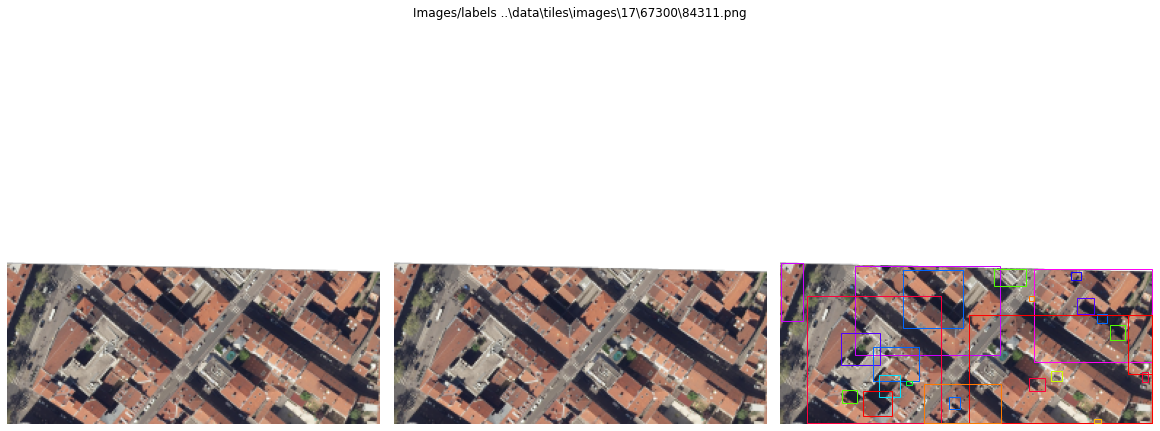

In [79]:
#visualisation des labels associés à chaque image et bboxes de l'annotation si bbox==True
# Un subbplot pour l'image, un subplot pour le label et un subplot Image/label/bbox
# Dans l'image choisie des batiments et de la végétalisation ont été labelisés. Les différentes bboxes issues de l'annotations apparaissent de couleur différente pour chaque objet.
Data.show_image_label(23, label=True, bbox=True)

In [38]:
print(Data.dataset.keys())

dict_keys(['info', 'images', 'categories', 'annotations'])


## Affichage des couples Images et Annotations générées par Geolabel_maker 

In [46]:
#visualisation des masques associés à chaque image. Un subplot par catégorie, Un dégradé de couleur par objet.
# Dans notre exemple ,nous avons deux catégories. Nous limitons donc l'affichage à 2 categories.

#exemple avec l'image dont l'id est 2.
image = Data.load_image(2)
mask, class_ids= Data.load_mask(2)
bbox=Data.load_bbox(2)
Data.display_top_masks(image, mask, class_ids, Data.class_names(),limit=2)

UnboundLocalError: local variable 'mask' referenced before assignment

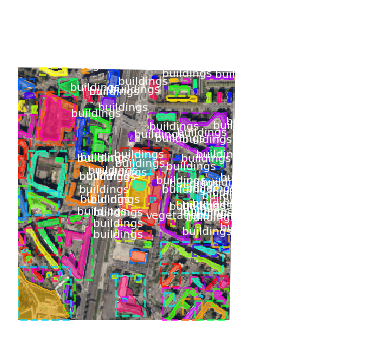

In [42]:
# De même la fonction display_all permet d'afficher les masks et bboxes du fichier annotation.
Data.display_all(image, bbox, mask,class_ids, Data.class_names(),figsize=(12,6))